Dynamics of continental accretion
======

This notebook outlines the Underworld model used in the Moresi (2014) paper 'Dynamics of continental accretion'. It reproduces the initial conditions shown in Extended Data Figure 1 and 2 and the numerics required for reproduce Figure 2.

"In order to better understand the behaviour of this ancient plate mar- gin and the growth of the Australian continent, we use three-dimensional (3D) dynamic models of a subducting slab, overriding plate and mantle, building on previous work14–16. The models have a four-layer subduct- ing plate with buoyancy and rheology of each layer pre-calculated from a half-space cooling model of 80 or 120 Myr age, and they include either a weak or a strong viscoplastic overriding plate (Table 1 and Extended Data Figs 1 and 2). The simulations are best understood by viewing movies of the time evolution (Table 1)."

**References**

Moresi, L., P. G. Betts, M. S. Miller, and R. A. Cayley. 2014. “Dynamics of Continental Accretion.” Nature 508 (7495): 245–48. [doi:10.1038/nature13033](https://www.nature.com/articles/nature13033)

**TODO!!!**

0. cohesion scaling doesn't seem to be corrent - pressure...
1. Confirm density change - crust  to eclogite
2. Include passive tracer swarms


In [1]:
import underworld as uw
from underworld import function as fn
from underworld.scaling import units as u
from underworld.scaling import dimensionalise, non_dimensionalise
from underworld.scaling import non_dimensionalise as nd
from underworld.scaling import dimensionalise as dim

import math
import glucifer
import numpy as np
import os
import scipy

import model_properties as modprop
import material_properties as matprop

In [2]:
outputPath = os.path.join(os.path.abspath("."),"output/")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.barrier()

**Scaling**

In [3]:
dRho =   80. * u.kilogram / u.meter**3 # matprop.ref_density
g    =   10. * u.meter / u.second**2   # modprop.gravity
H    = 1000. * u.kilometer #  modprop.boxHeight

# lithostatic pressure for mass-time-length
ref_stress = dRho * g * H
# viscosity of upper mante for mass-time-length
ref_viscosity = 1e20 * u.pascal * u.seconds

In [4]:
ref_time        = ref_viscosity/ref_stress
ref_length      = H
ref_mass        = (ref_viscosity*ref_length*ref_time).to_base_units()
ref_temperature = modprop.Tint - modprop.Tsurf

In [5]:
KL = ref_length       
KM = ref_mass         
Kt = ref_time
KT = ref_temperature

In [6]:
scaling_coefficients = uw.scaling.get_coefficients()
scaling_coefficients["[length]"] = KL.to_base_units()
scaling_coefficients["[time]"]   = Kt.to_base_units()
scaling_coefficients["[mass]"]   = KM.to_base_units()
scaling_coefficients["[temperature]"]   = KT.to_base_units()

In [7]:
scaling_coefficients

[mass],1.25e+37 kilogram
[length],1000000.0 meter
[temperature],1299.85 kelvin
[time],1.25e+11 second
[substance],1.0 mole


**Setup parameters**


In [8]:
xRes = 128 #256 # 32 # 256  
yRes =  48 #96 # 64 # 96
zRes =  96 # 32 # 96
dim = 2

In [9]:
# Domain
boxLength = nd(modprop.boxLength)
boxHeight = nd(modprop.boxHeight)
boxWidth  = nd(modprop.boxWidth)

**Create mesh and finite element variables**

In [10]:
if dim==2:
    elementRes  = (xRes, yRes)
    minCoord    = (0., -nd(boxHeight)) 
    maxCoord    = (nd(boxLength), 0.)
else:
    elementRes  = (xRes, yRes, zRes)
    minCoord    = (0., -nd(boxHeight), 0.) 
    maxCoord    = (nd(boxLength), 0., nd(boxWidth))

mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = elementRes, 
                                 minCoord    = minCoord,
                                 maxCoord    = maxCoord,
                               ) 

In [11]:
velocityField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

**Create a particle swarm**

In [12]:
swarm       = uw.swarm.Swarm( mesh=mesh )
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

materialIndex = swarm.add_variable( dataType="int", count=1 )

In [13]:
# I assume here the origin is a the top, front, middle
# 'middle' being the slab hinge at top, front
pert = 0.2  # nondimensional pert 
slab_xStart = 2500. * u.kilometer
slab_dx = 3000.0 * u.kilometer  # was 7000 km in Moresi 2014
slab_dy =  100.0 * u.kilometer
slab_dz = 3000.0 * u.kilometer # this is the entire domain width
slab_layers = 4

slab_crust = 7.0 * u.kilometer

In [14]:
backarc_dx = 1200. * u.kilometer
backarc_dy =  100. * u.kilometer
backarc_xStart = slab_xStart - backarc_dx
backarc_layers = 2

trans_dx =  350. * u.kilometer
trans_dy =  100. * u.kilometer
trans_xStart = slab_xStart - backarc_dx - trans_dx
trans_layers = 2

craton_dx = 750. * u.kilometer
craton_dy = 150. * u.kilometer
craton_xStart = slab_xStart - backarc_dx - trans_dx - craton_dx
craton_layers = 2

ribbon_dx =  500. * u.kilometer
ribbon_dy =   50. * u.kilometer
ribbon_dz = 1500. * u.kilometer 
ribbon_xStart = slab_xStart + 500. * u.kilometer

bouyStrip_dx = 500. * u.kilometer
bouyStrip_dy =  50. * u.kilometer
bouyStrip_xStart = slab_xStart + slab_dx - bouyStrip_dx

In [15]:
def slabGeo(x, y, dx, dy,):
    slabShape = np.array([ (x,y), (x+dx,y), (x+dx,y-dy), (x,y-dy), (x-pert,y-dy-pert), (x-pert,y-pert) ])
    return fn.shape.Polygon(slabShape)

In [16]:
def backArcGeo(x, y, dx, dy,):
    backArcShape = np.array([ (x,y), (x+dx,y), (x+dx-pert/2.,y-dy), (x,y-dy)])
    return fn.shape.Polygon(backArcShape)

In [17]:
def boxGeo(x, y, dx, dy):
    boxShape = np.array([(x,y), (x+dx,y), (x+dx,y-dy), (x,y-dy)]) 
    return (fn.shape.Polygon(boxShape))

In [18]:
top50km = fn.input()[1] > nd(-50.*u.kilometer)
fn_top50kmGeo = fn.branching.conditional( ( (top50km,  matprop.subplate1['index']),
                                            (   True,  matprop.subplate2['index']),  
                                          )
                                        )

outside_ribbon = fn.input()[2] > nd(ribbon_dz)
fn_ribbonGeo = fn.branching.conditional( ( (outside_ribbon, fn_top50kmGeo  ),
                                           (          True, matprop.ribbon['index']), 
                                         )
                                       )  

In [19]:
# Set materials
conditions = [ 
               ( fn.input()[1] < nd( -600.0 * 10**3 * u.meter ), matprop.lm['index']) ,

                # define ribbon gemetry
#               ( boxGeo(nd(ribbon_xStart), 0., nd(ribbon_dx), nd(ribbon_dy)), matprop.ribbon['index']),
               #( boxGeo(nd(ribbon_xStart), 0., nd(ribbon_dx), nd(ribbon_dy)), fn_ribbonGeo),

                # define buoyant strip gemetry
               ( boxGeo(nd(bouyStrip_xStart), 0., nd(bouyStrip_dx), nd(bouyStrip_dy)), matprop.buoyStrip['index']),

                # define slab geometery
               ( slabGeo(nd(slab_xStart), -0.*nd(slab_crust)         , nd(slab_dx), nd(slab_dy)/slab_layers), matprop.subplate1['index']),
               ( slabGeo(nd(slab_xStart), -1.*nd(slab_dy)/slab_layers, nd(slab_dx), nd(slab_dy)/slab_layers), matprop.subplate2['index']),
               ( slabGeo(nd(slab_xStart), -2.*nd(slab_dy)/slab_layers, nd(slab_dx), nd(slab_dy)/slab_layers), matprop.subplate3['index']),
               ( slabGeo(nd(slab_xStart), -3.*nd(slab_dy)/slab_layers, nd(slab_dx), nd(slab_dy)/slab_layers), matprop.subplate4['index']),
#                 # dedine back arc geometry
#                ( backArcGeo(nd(backarc_xStart),  -0.*nd(backarc_dy)/backarc_layers, nd(backarc_dx), nd(backarc_dy)), matprop.backArc1['index']),
#                ( backArcGeo(nd(backarc_xStart),  -1.*nd(backarc_dy)/backarc_layers, nd(backarc_dx), nd(backarc_dy)), matprop.backArc2['index']),
#                 # define transition gemetry
#                ( boxGeo(nd(trans_xStart),  -0.*nd(trans_dy)/trans_layers, nd(trans_dx), nd(trans_dy)), matprop.trans1['index']),
#                ( boxGeo(nd(trans_xStart),  -1.*nd(trans_dy)/trans_layers, nd(trans_dx), nd(trans_dy)), matprop.trans2['index']),
#                 # define craton gemetry
#                ( boxGeo(nd(craton_xStart), -0.*nd(craton_dy)/craton_layers, nd(craton_dx), nd(craton_dy)), matprop.craton1['index']),
#                ( boxGeo(nd(craton_xStart), -1.*nd(craton_dy)/craton_layers, nd(craton_dx), nd(craton_dy)), matprop.craton2['index']),
                # otherwise upper mantle!
                ( True, matprop.um['index']),
             ] 

In [20]:
materialIndex.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)

In [21]:
figsize=(1000,300)


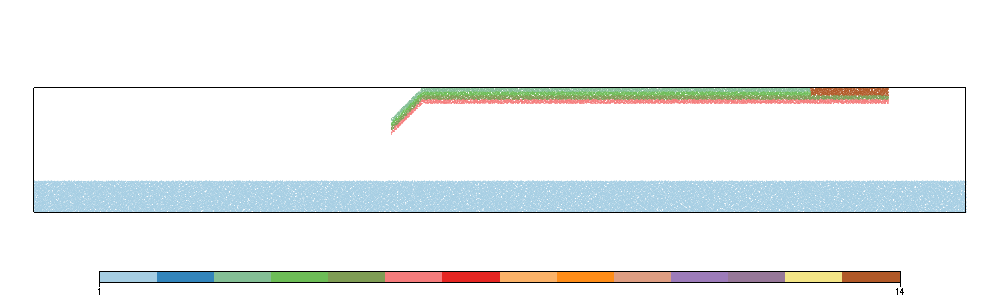

In [22]:
materialFilter = materialIndex > 0
figSwarm = glucifer.Figure(figsize=figsize)
swarmPlot = glucifer.objects.Points(swarm, materialIndex, materialFilter, colours='paired', fn_size=2., discrete=True)
figSwarm.append( swarmPlot )
figSwarm.show()

In [23]:
# if not glucifer.lavavu: raise KeyboardInterrupt #Stop notebook here if no vis enabled
# lv = figSwarm.window()
# lv.rotate(30)
# lv.zoom(-7)
# lv.redisplay()
# lv.axis()

In [24]:
##Set cohesion (max stress) fn
cohesionMap = {
                             matprop.um['index'] : nd(matprop.um['cohesion']), 
                             matprop.lm['index'] : nd(matprop.lm['cohesion']), 
                      matprop.subplate1['index'] : nd(matprop.subplate1['cohesion']), 
                      matprop.subplate2['index'] : nd(matprop.subplate2['cohesion']), 
                      matprop.subplate3['index'] : nd(matprop.subplate3['cohesion']),
                      matprop.subplate4['index'] : nd(matprop.subplate4['cohesion']), 
                       matprop.backArc1['index'] : nd(matprop.backArc1['cohesion']), 
                       matprop.backArc2['index'] : nd(matprop.backArc2['cohesion']), 
                         matprop.trans1['index'] : nd(matprop.trans1['cohesion']), 
                         matprop.trans2['index'] : nd(matprop.trans2['cohesion']), 
                        matprop.craton1['index'] : nd(matprop.craton1['cohesion']), 
                        matprop.craton2['index'] : nd(matprop.craton2['cohesion']), 
                         matprop.ribbon['index'] : nd(matprop.ribbon['cohesion']), 
                      matprop.buoyStrip['index'] : nd(matprop.buoyStrip['cohesion']),

#                              matprop.um['index'] : 1e3, 
#                              matprop.lm['index'] : 1e3,
#                       matprop.subplate1['index'] : 0.01, 
#                       matprop.subplate1['index'] : 0.1,
#                       matprop.subplate2['index'] : 0.03, 
#                       matprop.subplate3['index'] : 0.1, 
#                       matprop.subplate4['index'] : 1e3, 
#                       matprop.buoyStrip['index'] : 1e3,    
                    }
cohesionFn = fn.branching.map( fn_key = materialIndex, mapping = cohesionMap )


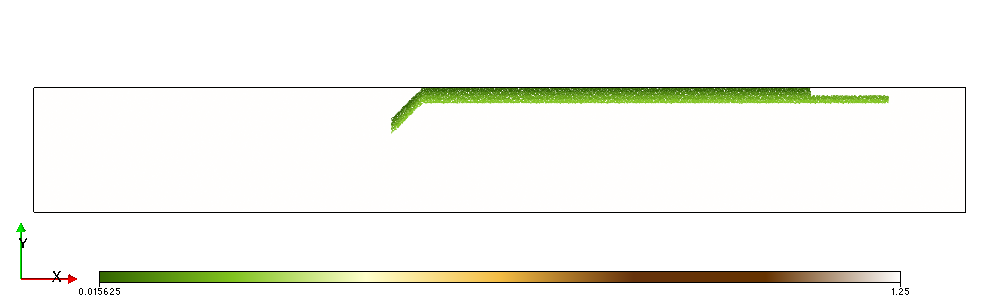

In [25]:
figCohesion = glucifer.Figure(figsize=figsize, axis=True)
figCohesion.append( glucifer.objects.Points(swarm, cohesionFn, colours='dem1', fn_size=2.))#, logScale=True) )
figCohesion.show()

In [26]:
##Set linear viscosity fn
linearViscosityMap = {       matprop.um['index'] : nd(matprop.um['viscosity']), 
                             matprop.lm['index'] : nd(matprop.lm['viscosity']), 
                      matprop.subplate1['index'] : nd(matprop.subplate1['viscosity']), 
                      matprop.subplate2['index'] : nd(matprop.subplate2['viscosity']), 
                      matprop.subplate3['index'] : nd(matprop.subplate3['viscosity']), 
                      matprop.subplate4['index'] : nd(matprop.subplate4['viscosity']), 
                       matprop.backArc1['index'] : nd(matprop.backArc1['viscosity']), 
                       matprop.backArc2['index'] : nd(matprop.backArc2['viscosity']), 
                         matprop.trans1['index'] : nd(matprop.trans1['viscosity']), 
                         matprop.trans2['index'] : nd(matprop.trans2['viscosity']), 
                        matprop.craton1['index'] : nd(matprop.craton1['viscosity']), 
                        matprop.craton2['index'] : nd(matprop.craton2['viscosity']), 
                         matprop.ribbon['index'] : nd(matprop.ribbon['viscosity']), 
                      matprop.buoyStrip['index'] : nd(matprop.buoyStrip['viscosity']),
                    }



linearViscosityFn = fn.branching.map( fn_key = materialIndex, mapping = linearViscosityMap )

In [27]:
# we are now working in nd viscosity
minViscosity = 1.  #* u.pascal * u.second # * ref_viscosity,
maxViscosity = 1.0e5  * u.pascal * u.second # * ref_viscosity,


strainRate_2ndInvariant = fn.tensor.second_invariant( fn.tensor.symmetric( velocityField.fn_gradient ))

# This is what we're looking for...
#cohesionFn = 0.06
vonMises    = 0.5 * cohesionFn / (strainRate_2ndInvariant + 1.0e-18)     
viscosityFn = fn.exception.SafeMaths( fn.misc.max(minViscosity, fn.misc.min(vonMises, linearViscosityFn) ))


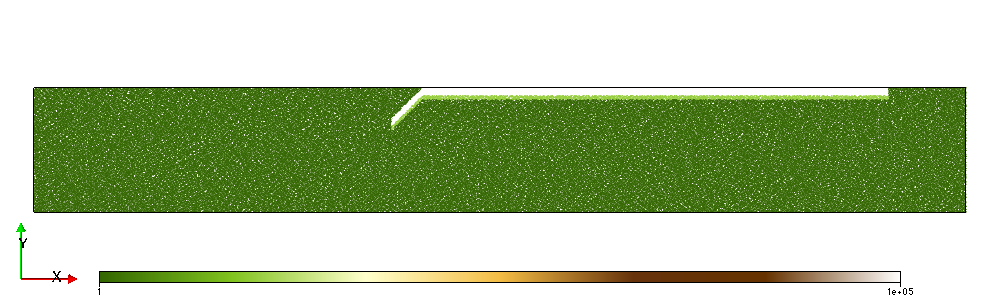

In [28]:
figViscosity = glucifer.Figure(figsize=figsize, axis=True)
figViscosity.append( glucifer.objects.Points(swarm, viscosityFn, colours='dem1', fn_size=2.))#, logScale=True) )
figViscosity.show()

In [29]:
# if not glucifer.lavavu: raise KeyboardInterrupt #Stop notebook here if no vis enabled
# lv = figViscosity.window()
# lv.rotate(30)
# lv.zoom(-7)
# lv.redisplay()
# lv.axis()

**Define temperature and density functions**

In [30]:
coord = fn.input()
depthFn = -1.0 * boxHeight * coord[1] 

In [31]:
kappa   = 1e-6   * u.meter**2 / u.second 
# for oceanic lithosphere thickness
def half_space_cooling(depth,age):
    return nd(modprop.Tsurf) + nd(modprop.Tint-modprop.Tsurf) * fn.math.erf(depth/(2*np.sqrt(nd(age*kappa))))

In [32]:
# age of oceanic lithosphere
age = 80. * 10**6 * u.year

In [33]:
# temperature profile of lithosphere
temperature = half_space_cooling(nd(depthFn), nd(age))

**Eclogite transition**

We assume that the oceanic crust transforms instantaneously and completely to eclogite at a depth of 150 km (density 3,500 kg m23 at the surface temperature).

In [34]:
below_150km = fn.input()[1] < nd(-300.*u.kilometers)
fn_conditional = fn.branching.conditional( 
                                           ( 
                                             ( below_150km, nd(matprop.subplate1['density2'])),
                                             (        True, nd(matprop.subplate1['density'])), 
                                           ) 
                                          )

In [35]:
#Set density fn
rhoMap = {
#                              matprop.um['index'] : nd(matprop.um['density']), 
#                              matprop.lm['index'] : nd(matprop.lm['density']), 
#                       matprop.subplate1['index'] : fn_conditional,
#                       matprop.subplate2['index'] : nd(matprop.subplate2['density']), 
#                       matprop.subplate3['index'] : nd(matprop.subplate3['density']), 
#                       matprop.subplate4['index'] : nd(matprop.subplate4['density']), 
                       matprop.backArc1['index'] : nd(matprop.backArc1['density']), 
                       matprop.backArc2['index'] : nd(matprop.backArc2['density']), 
                         matprop.trans1['index'] : nd(matprop.trans1['density']), 
                         matprop.trans2['index'] : nd(matprop.trans2['density']), 
                        matprop.craton1['index'] : nd(matprop.craton1['density']), 
                        matprop.craton2['index'] : nd(matprop.craton2['density']), 
                         matprop.ribbon['index'] : nd(matprop.ribbon['density']), 
#                       matprop.buoyStrip['index'] : nd(matprop.buoyStrip['density']),

                             matprop.um['index'] : 0., 
                             matprop.lm['index'] : 0., 
                      matprop.subplate1['index'] : 0.,
                      matprop.subplate2['index'] : 0.6, 
                      matprop.subplate3['index'] : 0.4, 
                      matprop.subplate4['index'] : 0.2, 
                      matprop.buoyStrip['index'] : 0.,
}

rhoFn = fn.branching.map( fn_key = materialIndex, mapping = rhoMap )

In [36]:
densityFn = (rhoFn - rhoFn * nd(ref_temperature) * nd(matprop.alpha))


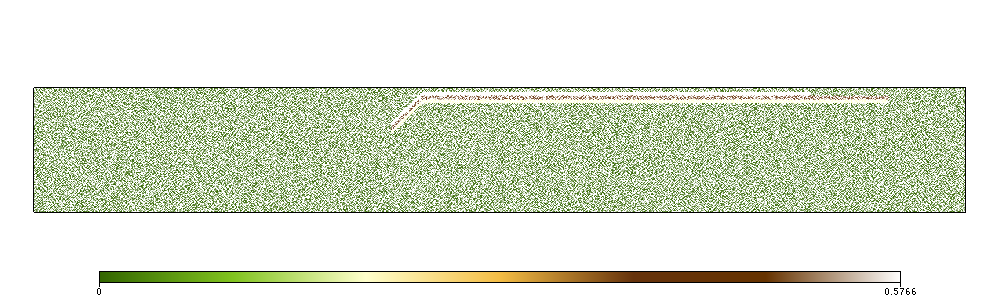

In [37]:
figDensity = glucifer.Figure(figsize=figsize)
figDensity.append( glucifer.objects.Points(swarm, densityFn, colours='dem1'))
figDensity.show()

**Set the density function, vertical unit vector and Buoyancy Force function**


In [38]:
# Define our vertical unit vector using a python tuple
if dim == 2:
    z_hat = ( 0.0, 1.0)
else:
    z_hat = ( 0.0, 1.0, 0.0 )    

# now create a buoyancy force vector
buoyancyFn = -1.0 * densityFn * z_hat

**Set initial and boundary conditions**

In [39]:
# set initial conditions (and boundary values)
if dim==2:
    velocityField.data[:] = [0.,0.]
else:
    velocityField.data[:] = [0.,0.,0.]
pressureField.data[:] = 0.

# send boundary condition information to underworld
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
if dim==2:
    freeSlipBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                                   indexSetsPerDof = ( iWalls, jWalls) ) 
    
if dim==3:
    kWalls = mesh.specialSets["MinK_VertexSet"] + mesh.specialSets["MaxK_VertexSet"]    
    freeSlipBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                                   indexSetsPerDof = ( iWalls, jWalls, kWalls) ) 

**System Setup**

In [40]:
# Initial linear slab viscosity setup
stokes = uw.systems.Stokes(    velocityField = velocityField, 
                               pressureField = pressureField,
                               voronoi_swarm = swarm, 
                               conditions    = freeSlipBC,
                               fn_viscosity  = viscosityFn, 
                               fn_bodyforce  = buoyancyFn )
# Create solver & solve
solver = uw.systems.Solver(stokes)

In [41]:
# use "lu" direct solve if running in serial
if(uw.nProcs==1):
    solver.set_inner_method("lu")

In [42]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

**Analysis tools**

In [43]:
#The root mean square Velocity
velSquared = uw.utils.Integral( fn.math.dot(velocityField,velocityField), mesh )
area = uw.utils.Integral( 1., mesh )
Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )

**May need to do this within time step loop**

In [44]:
# # update within time step loop
# densityFn = fn.branching.conditional( eclogite_conditions ).evaluate(swarm)

In [45]:
figSwarm.append(glucifer.objects.VectorArrows(mesh, velocityField))
figViscosity.append(glucifer.objects.VectorArrows(mesh, velocityField))

**Checkpoint**

In [46]:
# save mesh
meshHnd = mesh.save(outputPath+'mesh.h5')
 

In [47]:
#swarm.save(filename='./swarm.h5')
step = 0
swarmHnd        = swarm.save(        outputPath+'swarm.'       + str(step).zfill(5) +'.h5')

In [48]:
   # define checkpointing file
def checkpoint():
    # save swarms
    swarmHnd        = swarm.save(        outputPath+'swarm.'       + str(step).zfill(5) +'.h5')

    # save swarm variables
    materialIndexHnd  = materialIndex.save(  outputPath +'materialIndex.'  + str(step).zfill(5) +'.h5')
    
    # save mesh variable
    velocityHnd = velocityField.save(outputPath+'velocityField.'+ str(step).zfill(5) +'.h5', meshHnd)
    pressureHnd = pressureField.save(outputPath+'pressureField.'+ str(step).zfill(5) +'.h5', meshHnd)

    # and the xdmf files
    velocityField.xdmf(  outputPath+'velocityField.' +str(step).zfill(5)+'.xdmf',velocityHnd,      "velocity",      meshHnd, "mesh", modeltime=time)
    pressureField.xdmf(  outputPath+'pressureField.' +str(step).zfill(5)+'.xdmf',pressureHnd,      "pressure",      meshHnd, "mesh", modeltime=time)
    materialIndex.xdmf(  outputPath+'materialIndex.' +str(step).zfill(5)+'.xdmf',materialIndexHnd, "materialIndex", swarmHnd,"swarm",modeltime=time)


Main simulation loop
=======

The main time stepping loop begins here. Inside the time loop the velocity field is solved for via the Stokes system solver and then the swarm is advected using the advector integrator. Basic statistics are output to screen each timestep.

In [49]:
time = 0.  # Initial time
step = 0   # Initial timestep
maxSteps = 10      # Maximum timesteps (201 is recommended)
steps_output = 1   # output every 10 timesteps
checkoutput  = 1

In [50]:
# define an update function
def update():
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt()
    # Advect using this timestep size.
    advector.integrate(dt)
    return time+dt, step+1

In [51]:
solver.set_inner_method('lu')

In [52]:
while step < maxSteps*10:
    # Solve non linear Stokes system
    solver.solve(nonLinearIterate=True)#, print_stats=True)
    # output figure to file at intervals = steps_output
    if step % steps_output == 0 or step == maxSteps-1:
        #Important to set the timestep for the store object here or will overwrite previous step
        figSwarm.save(    outputPath + "particle"    + str(step).zfill(4))
        figViscosity.save(   outputPath + "viscosity"   + str(step).zfill(4))
        figDensity.save(     outputPath + "density"     + str(step).zfill(4))
        
        Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )
        print('step = {0:6d}; time = {1:.3e}; Vrms = {2:.3e}, time(yr) = {3:.3e};'.format(step,time,Vrms,dimensionalise(time, u.year).magnitude))

    if step % checkoutput == 0:
        checkpoint()
    # update
    time,step = update()

step =      0; time = 0.000e+00; Vrms = 2.227e-05, time(yr) = 0.000e+00;
step =      1; time = 6.365e+01; Vrms = 2.191e-05, time(yr) = 2.521e+05;
step =      2; time = 1.312e+02; Vrms = 2.145e-05, time(yr) = 5.197e+05;
step =      3; time = 1.990e+02; Vrms = 2.088e-05, time(yr) = 7.883e+05;
step =      4; time = 2.716e+02; Vrms = 1.985e-05, time(yr) = 1.076e+06;
step =      5; time = 3.497e+02; Vrms = 1.934e-05, time(yr) = 1.385e+06;
step =      6; time = 4.302e+02; Vrms = 1.819e-05, time(yr) = 1.704e+06;
step =      7; time = 5.190e+02; Vrms = 1.728e-05, time(yr) = 2.056e+06;
step =      8; time = 6.147e+02; Vrms = 1.685e-05, time(yr) = 2.435e+06;
step =      9; time = 7.138e+02; Vrms = 1.665e-05, time(yr) = 2.827e+06;
step =     10; time = 8.152e+02; Vrms = 1.601e-05, time(yr) = 3.229e+06;
step =     11; time = 9.250e+02; Vrms = 1.525e-05, time(yr) = 3.664e+06;
step =     12; time = 1.042e+03; Vrms = 1.648e-05, time(yr) = 4.128e+06;
step =     13; time = 1.156e+03; Vrms = 1.634e-05, 


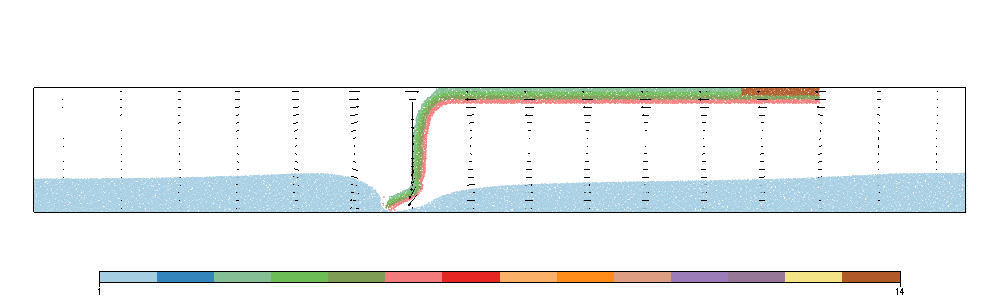

In [53]:
figSwarm.show()

In [54]:
dimensionalise(time, u.year).magnitude

25370406.976024814

In [55]:
# if not glucifer.lavavu: raise KeyboardInterrupt #Stop notebook here if no vis enabled
# lv = figSwarm.window()
# lv.rotate(30)
# lv.zoom(-7)
# lv.redisplay()
# lv.axis()


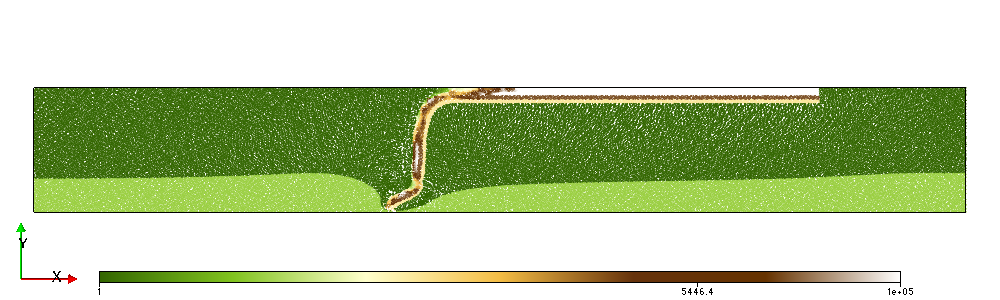

In [57]:
figViscosity = glucifer.Figure(figsize=figsize, axis=True)
figViscosity.append( glucifer.objects.Points(swarm, viscosityFn, colours='dem1', fn_size=2., logScale=True) )
figViscosity.show()